In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import csv

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import hyperparameter optimization packages
try:
    from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
except ImportError:
    print("\nWARNING: hyperopt package is not installed. You will be unable to use section 5.")
    pass

#Import decoder functions
from Neural_Decoding.decoders import DenseNNDecoder

In [2]:
#Get Data in the correct format
#enter the folder where the data is
folder='../SR-Task/preprocessed_data/'

with open(folder+'all_data_SR.pickle','rb') as f:
    #If using python 3
    M1, PMd, M1_PMd,pos_binned,vels_binned=pickle.load(f,encoding='latin1') 

In [13]:
#neural_data_combined = [M1, PMd, M1_PMd]
neural_data_combined = [M1, M1_PMd]
#kinematics = [pos_binned, vels_binned]
kinematics = [vels_binned]

test = [pos_binned]
R2 = np.empty((2,1))

for row in tqdm(range(2)):
    neural_data = neural_data_combined[row]
    col = 0
    for output in kinematics:
        # Preprocess data
        bins_before=6 #How many bins of neural data prior to the output are used for decoding
        bins_current=1 #Whether to use concurrent time bin of neural data
        bins_after=0 #How many bins of neural data after the output are used for decoding

        # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
        # Function to get the covariate matrix that includes spike history from previous bins
        X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

        # Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
        #Put in "flat" format, so each "neuron / time" is a single feature
        X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
        
        # Output covariates
        #Set decoding output
        y=output
        
        #Set what part of data should be part of the training/testing/validation sets
        training_range=[0, 0.7]
        testing_range=[0.7, 0.85]
        valid_range=[0.85,1]
        
        
        num_examples=X.shape[0]

        #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
        #This makes it so that the different sets don't include overlapping neural data
        training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
        testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
        valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

        #Get training data
        X_train=X[training_set,:,:]
        X_flat_train=X_flat[training_set,:]
        y_train=y[training_set,:]

        #Get testing data
        X_test=X[testing_set,:,:]
        X_flat_test=X_flat[testing_set,:]
        y_test=y[testing_set,:]

        #Get validation data
        X_valid=X[valid_set,:,:]
        X_flat_valid=X_flat[valid_set,:]
        y_valid=y[valid_set,:]
        
        # Process covariates
        #Z-score "X" inputs. 
        X_train_mean=np.nanmean(X_train,axis=0)
        X_train_std=np.nanstd(X_train,axis=0)
        X_train=(X_train-X_train_mean)/X_train_std
        X_test=(X_test-X_train_mean)/X_train_std
        X_valid=(X_valid-X_train_mean)/X_train_std

        #Z-score "X_flat" inputs. 
        X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
        X_flat_train_std=np.nanstd(X_flat_train,axis=0)
        X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
        X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
        X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

        #Zero-center outputs
        y_train_mean=np.mean(y_train,axis=0)
        y_train=y_train-y_train_mean
        y_test=y_test-y_train_mean
        y_valid=y_valid-y_train_mean
        
        
        #Do optimization
        # Define parameters for hyperoptimisation
        def dnn_evaluate2(params):
            #Put parameters in proper format
            num_units=int(params['num_units'])
            frac_dropout=float(params['frac_dropout'])
            n_epochs=int(params['n_epochs'])
            model_dnn=DenseNNDecoder(units=[num_units,num_units],dropout=frac_dropout,num_epochs=n_epochs) #Define model
            model_dnn.fit(X_flat_train,y_train) #Fit model
            y_valid_predicted_dnn=model_dnn.predict(X_flat_valid) #Get validation set predictions
            return -np.mean(get_R2(y_valid,y_valid_predicted_dnn)) #Return -R2 value of validation set

        #The range of values I'll look at for the parameter
        #"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
        #So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
        #"hp.uniform" looks at continuously spaced values
        space = {
            'frac_dropout': hp.uniform('frac_dropout', 0., 0.5),
            'num_units': hp.quniform('num_units', 50,700,10),
            'n_epochs': hp.quniform('n_epochs', 2,15,1),
        }

        #object that holds iteration results
        trials = Trials()
        
        #Set the number of evaluations below (20 in this example)
        hyperoptBest = fmin(dnn_evaluate2, space, algo=tpe.suggest, max_evals=5, trials=trials)

        #print("R2_validation",-trials.best_trial['result']['loss'])
        
        #print(type(hyperoptBest['num_units']))
        #print(type(hyperoptBest['frac_dropout']))
        #print(type(hyperoptBest['n_epochs']))
        #Declare model
        model_dnn=DenseNNDecoder(units=int(hyperoptBest['num_units']),dropout=hyperoptBest['frac_dropout'],num_epochs=int(hyperoptBest['n_epochs']))

        #Fit model
        model_dnn.fit(X_flat_train,y_train)

        #Get predictions
        y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)
        
        if row == 0:
            predictions = y_valid_predicted_dnn
        else:
            predictions = [predictions, y_valid_predicted_dnn]
        
        R2_vw = r2_score(y_valid,y_valid_predicted_dnn, multioutput='variance_weighted')
        
        # Store the R2 value
        R2[row,col] = R2_vw
        # increase the column counter
        col += 1

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.77s/trial, best loss: -0.8084152805586264]


 50%|██████████████████████████████████████████                                          | 1/2 [00:28<00:28, 28.12s/it]


100%|█████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.08s/trial, best loss: -0.8411860319604081]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:18<00:00, 39.48s/it]


In [6]:
print(R2)

[[0.59327313]
 [0.65728712]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


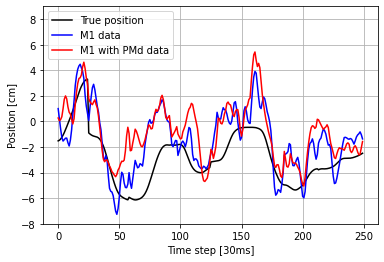

In [11]:
fig_x_dnn=plt.figure()
plt.plot(y_valid[1050:1300,0],'k',label="True position")
plt.plot(predictions[0][1050:1300,0],'b',label="M1 data")
plt.plot(predictions[1][1050:1300,0],'r',label="M1 with PMd data")
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
plt.ylim([-8, 9])
#plt.savefig('figures/SR_example_predictions/FFNN_SR_pos_X.eps', format='eps')
#plt.savefig('figures/SR_example_predictions/FFNN_SR_pos_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


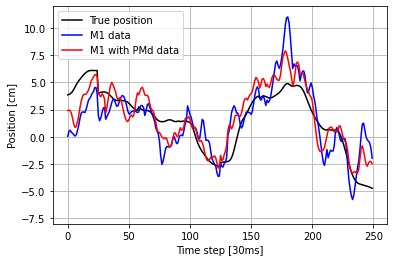

In [12]:
fig_x_dnn=plt.figure()
plt.plot(y_valid[1050:1300,1],'k',label="True position")
plt.plot(predictions[0][1050:1300,1],'b',label="M1 data")
plt.plot(predictions[1][1050:1300,1],'r',label="M1 with PMd data")
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
plt.ylim([-8, 12])
#plt.savefig('figures/SR_example_predictions/FFNN_SR_pos_Y.eps', format='eps')
#plt.savefig('figures/SR_example_predictions/FFNN_SR_pos_Y.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


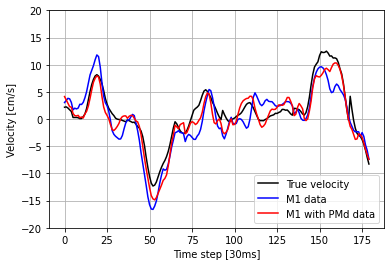

In [16]:
fig_x_dnn=plt.figure()
plt.plot(y_valid[1170:1350,0],'k',label="True velocity")
plt.plot(predictions[0][1170:1350,0],'b',label="M1 data")
plt.plot(predictions[1][1170:1350,0],'r',label="M1 with PMd data")
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Velocity [cm/s]")
plt.ylim([-20, 20])
#plt.savefig('figures/SR_example_predictions/FFNN_SR_vel_X.eps', format='eps')
#plt.savefig('figures/SR_example_predictions/FFNN_SR_vel_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


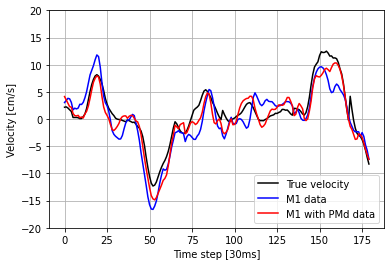

In [17]:
fig_x_dnn=plt.figure()
plt.plot(y_valid[1170:1350,0],'k',label="True velocity")
plt.plot(predictions[0][1170:1350,0],'b',label="M1 data")
plt.plot(predictions[1][1170:1350,0],'r',label="M1 with PMd data")
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Velocity [cm/s]")
plt.ylim([-20, 20])
#plt.savefig('figures/SR_example_predictions/FFNN_SR_vel_Y.eps', format='eps')
#plt.savefig('figures/SR_example_predictions/FFNN_SR_vel_Y.png')
plt.show()